In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import lightning as L
import optuna
import warnings

from lightning.pytorch.callbacks import Callback
#from pytorch_forecasting.metrics.quantile import QuantileLoss
from optuna.integration import PyTorchLightningPruningCallback

C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\DeepLearningEnergyForecasting\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random_seed = 1923

In [3]:
# Set Torch settings
torch.set_default_dtype(torch.float32)
torch.set_float32_matmul_precision('medium')
L.seed_everything(random_seed, workers = True)
warnings.filterwarnings("ignore", ".*does not have many workers.*")

Seed set to 1923


In [4]:
# Plot settings
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [5]:
output_dir = "./OutputData/"

In [6]:
df = pd.read_csv(output_dir + "train_data.csv")
df["time"] = pd.to_datetime(df["time"])

In [7]:
df

,time,consumption_MWh,consumption_lag2,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
0,2018-01-01 02:00:00,24635.32,27412.81,2,7.071068e-01,7.071068e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
1,2018-01-01 03:00:00,23872.12,26324.39,3,8.660254e-01,5.000000e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
2,2018-01-01 04:00:00,23194.89,24635.32,4,9.659258e-01,2.588190e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
3,2018-01-01 05:00:00,23071.96,23872.12,5,1.000000e+00,6.123234e-17,7.818315e-01,0.62349,5.000000e-01,0.866025
4,2018-01-01 06:00:00,23267.90,23194.89,6,9.659258e-01,-2.588190e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...
52577,2023-12-31 19:00:00,35090.93,34549.42,52579,-8.660254e-01,5.000000e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52578,2023-12-31 20:00:00,33310.94,36193.59,52580,-7.071068e-01,7.071068e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52579,2023-12-31 21:00:00,32083.96,35090.93,52581,-5.000000e-01,8.660254e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52580,2023-12-31 22:00:00,30469.49,33310.94,52582,-2.588190e-01,9.659258e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000


## Data prep: Getting input & output sequences

We will create a "shifted dataset" where each row at time T contains the following columns:
- Target value at T (consumption lead T+1),
- Past value at T (consumption lag T-2),
- Time covariates at T.

In [8]:
# Get shifted dataset, drop last row due to unknown target
df_shifted = df.copy()
df_shifted["consumption_MWh"] = df_shifted.consumption_MWh.shift(-1)
df_shifted = df_shifted.dropna()

In [9]:
df_shifted

,time,consumption_MWh,consumption_lag2,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
0,2018-01-01 02:00:00,23872.12,27412.81,2,0.707107,7.071068e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
1,2018-01-01 03:00:00,23194.89,26324.39,3,0.866025,5.000000e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
2,2018-01-01 04:00:00,23071.96,24635.32,4,0.965926,2.588190e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
3,2018-01-01 05:00:00,23267.90,23872.12,5,1.000000,6.123234e-17,7.818315e-01,0.62349,5.000000e-01,0.866025
4,2018-01-01 06:00:00,23875.44,23194.89,6,0.965926,-2.588190e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...
52576,2023-12-31 18:00:00,35090.93,32670.06,52578,-0.965926,2.588190e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52577,2023-12-31 19:00:00,33310.94,34549.42,52579,-0.866025,5.000000e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52578,2023-12-31 20:00:00,32083.96,36193.59,52580,-0.707107,7.071068e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52579,2023-12-31 21:00:00,30469.49,35090.93,52581,-0.500000,8.660254e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000


Every input sequence will be the last 72 hours before 16:00, and every output sequence will be the next 32 hours after 16:00.

In [10]:
n_steps = len(df_shifted) 
input_length = 72 # T-L to T hours as input
input_dims = 8 # Consumption lag 2, trend, 6 cyclical columns as features
output_length = 32 # We are only interested in predicting T+8 to 32, but we have to predict from T+1 because we need hidden states at each time step.

In [11]:
# Find the index of the first 16:00 row in the data, where the index is bigger than input_length - 1. This will be the first T.
first_t = df_shifted.loc[(df_shifted.time.dt.hour == 16) & (df_shifted.index >= input_length - 1)].index.values[0]

In [12]:
first_t 

86

In [13]:
# Find the index of the last 16:00 row in the data, with 32 time steps after it. This will be the last T.
last_t = df_shifted.loc[(df_shifted.time.dt.hour == 16) & (df_shifted.index + output_length - 1 <= df.index.values[-1])].index.values[-2]

In [14]:
last_t 

52526

Each input sequence will contain the following:
- Consumption lag 2 at [T - input_length, T] (past targets),
- Time covariates at [T - input_length + 1, T+1 ] (future known covariates).

In [15]:
# One input sequence
input_seq = pd.concat([
    df_shifted.iloc[(first_t - input_length):first_t, 0], # Time
    df_shifted.iloc[(first_t - input_length):first_t, 2], # Past target
    df_shifted.shift(-1).iloc[(first_t - input_length):(first_t), 3:] # Future known covariates
], axis = 1)

Each output sequence will contain the following:
- Consumption at [T+1, T + output_length] (future targets),
- Time covariates at [T+2, T + output_length + 1] (future known covariates for prediction steps after T+1)

In [16]:
# One output sequence
output_seq = pd.concat([
    df_shifted.iloc[first_t:(first_t + output_length), 0], # Time 
    df_shifted.iloc[first_t:(first_t + output_length), 1], # Future target
    df_shifted.shift(-1).iloc[first_t:(first_t + output_length), 3:] # Future known covariates
], axis = 1)

In [17]:
input_seq.iloc[-5:]

,time,consumption_lag2,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
81,2018-01-04 11:00:00,39641.36,84.0,-0.258819,-0.965926,-0.433884,-0.900969,0.5,0.866025
82,2018-01-04 12:00:00,40593.83,85.0,-0.500000,-0.866025,-0.433884,-0.900969,0.5,0.866025
83,2018-01-04 13:00:00,40955.07,86.0,-0.707107,-0.707107,-0.433884,-0.900969,0.5,0.866025
84,2018-01-04 14:00:00,39505.55,87.0,-0.866025,-0.500000,-0.433884,-0.900969,0.5,0.866025
85,2018-01-04 15:00:00,39635.29,88.0,-0.965926,-0.258819,-0.433884,-0.900969,0.5,0.866025


In [18]:
output_seq[:5]

,time,consumption_MWh,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
86,2018-01-04 16:00:00,40487.65,89.0,-1.000000,-1.836970e-16,-0.433884,-0.900969,0.5,0.866025
87,2018-01-04 17:00:00,39936.25,90.0,-0.965926,2.588190e-01,-0.433884,-0.900969,0.5,0.866025
88,2018-01-04 18:00:00,38772.68,91.0,-0.866025,5.000000e-01,-0.433884,-0.900969,0.5,0.866025
89,2018-01-04 19:00:00,38113.86,92.0,-0.707107,7.071068e-01,-0.433884,-0.900969,0.5,0.866025
90,2018-01-04 20:00:00,36758.94,93.0,-0.500000,8.660254e-01,-0.433884,-0.900969,0.5,0.866025


In [19]:
df_shifted.iloc[81:90]

,time,consumption_MWh,consumption_lag2,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
81,2018-01-04 11:00:00,39505.55,39641.36,83,1.224647e-16,-1.000000e+00,-0.433884,-0.900969,0.5,0.866025
82,2018-01-04 12:00:00,39635.29,40593.83,84,-2.588190e-01,-9.659258e-01,-0.433884,-0.900969,0.5,0.866025
83,2018-01-04 13:00:00,39952.75,40955.07,85,-5.000000e-01,-8.660254e-01,-0.433884,-0.900969,0.5,0.866025
84,2018-01-04 14:00:00,39649.45,39505.55,86,-7.071068e-01,-7.071068e-01,-0.433884,-0.900969,0.5,0.866025
85,2018-01-04 15:00:00,40063.17,39635.29,87,-8.660254e-01,-5.000000e-01,-0.433884,-0.900969,0.5,0.866025
86,2018-01-04 16:00:00,40487.65,39952.75,88,-9.659258e-01,-2.588190e-01,-0.433884,-0.900969,0.5,0.866025
87,2018-01-04 17:00:00,39936.25,39649.45,89,-1.000000e+00,-1.836970e-16,-0.433884,-0.900969,0.5,0.866025
88,2018-01-04 18:00:00,38772.68,40063.17,90,-9.659258e-01,2.588190e-01,-0.433884,-0.900969,0.5,0.866025
89,2018-01-04 19:00:00,38113.86,40487.65,91,-8.660254e-01,5.000000e-01,-0.433884,-0.900969,0.5,0.866025


In the input sequence, we pair every past target value at T with the future covariates at T+1.
\
In the output sequence, we pair every future target value at T+1 with the future covariates at T+2.
\
This is because the future target at T+1 and the future covariates at T+2 will be the past target & future covariates in the next prediction step. 
\
LSTMs and RNNs can only forecast 1 step at a time due to needing a chain of hidden & cell states. 
\
For validation & prediciton steps, we will replace the future targets after T+1 with predicitons from the previous step, as these will be unknown values at real prediciton time.
\
During training, we still use the real target values for all prediciton steps "in hindsight", as training with predictions as the target may mislead the model. In a real life scenario, we'd have the "hindsight" values available in the historic data, just like we do here.

In [20]:
n_sequences = (last_t - first_t) // 24 + 1 # Number of 16:00 rows followed by a sufficient input / output sequence
print("Number of possible sequences: " + f"{n_sequences}")

Number of possible sequences: 2186


In [21]:
# Get all sequences
for t in range(first_t, last_t + 1, 24):

    # Get input sequence
    new_input = pd.concat([
        df_shifted.iloc[(t - input_length):t, 0], # Time
        df_shifted.iloc[(t - input_length):t, 2], # Past target
        df_shifted.shift(-1).iloc[(t - input_length):t, 3:] # Future known covariates
        ], axis = 1)
    new_input = new_input.set_index("time")

    # Get output sequence
    new_output = pd.concat([
        df_shifted.iloc[t:(t + output_length), 0], # Time 
        df_shifted.iloc[t:(t + output_length), 1], # Future target
        df_shifted.shift(-1).iloc[t:(t + output_length), 3:] # Future known covariates
        ], axis = 1)
    new_output = new_output.set_index("time")

    if t == first_t:

        # Initialize lists of sequences
        input_sequences = [new_input]
        output_sequences = [new_output]
        
    else:
        # Concatenate to arrays of sequences
        input_sequences.append(new_input)
        output_sequences.append(new_output)


In [22]:
len(input_sequences)

2186

In [23]:
len(output_sequences)

2186

## Preprocessing: Custom scaler, Torch datasets & dataloaders

In [24]:
# Get indices for train - val - test split
sixty_percent = int(len(input_sequences) * 0.6)
twenty_percent = int(len(input_sequences) * 0.2)
train_end = sixty_percent
val_end = sixty_percent + twenty_percent

In a stateful LSTM, the last timestep's hidden & cell state for observation 1 in batch 1 will be used as the initial hidden & cell state for observation 1 in batch 2.
\
Because of this, we need batches of constant size through training, val. and testing data. We'll divide the lengths of each data fold with the batch size, drop the remainder from the start of the training folds & the end of the val. & test folds.

In [25]:
# Perform train - val - test split
batch_size = 64

# Training data at validation step
tr_input, tr_output = input_sequences[0:train_end], output_sequences[0:train_end]
remainder = len(tr_input) % batch_size
tr_input, tr_output = tr_input[remainder:], tr_output[remainder:]

# Training data at testing step
train_input, train_output = input_sequences[0:val_end], output_sequences[0:val_end]
remainder = len(train_input) % batch_size
train_input, train_output = train_input[remainder:], train_output[remainder:]

# Validation data
val_input, val_output = input_sequences[train_end:val_end], output_sequences[train_end:val_end]
remainder = len(val_input) % batch_size
val_input, val_output = val_input[:-remainder], val_output[:-remainder]

# Testing data
test_input, test_output = input_sequences[val_end:], output_sequences[val_end:]
remainder = len(test_input) % batch_size
test_input, test_output = test_input[:-remainder], test_output[:-remainder]

We have to scale the past consumption & trend values in the input sequences, and the future consumption & trend values in the output sequences, because they'll be the past values as the forecast horizon expands.
\
We also need the ability to backtransform the network's final predictions accordingly. We need a class instead of a function.

In [26]:
# Define scaling class for sequence data
class sequence_scaler:

    def __init__(self, feature_range = (-1, 1)):
        self.lower = feature_range[0]
        self.upper = feature_range[1]

    def fit(self, input_df, output_df):

        # Get input & output sequences as 3D arrays
        # The time index will be skipped, yielding shape (N, seq_length, seq_dims)
        input = np.stack(input_df, axis = 0)
        output = np.stack(output_df, axis = 0)

        # Get number of dimensions
        self.num_dimensions = input.shape[2]
        
        # Extract & save minimum, maximum for each dimension
        dimensions_mini = []
        dimensions_maxi = []
        for dimension in range(0, self.num_dimensions):
            min = np.min([
                np.min(input[:, :, dimension]),
                np.min(output[:, :, dimension])
            ])
            dimensions_mini.append(min)

            max = np.max([
                np.max(input[:, :, dimension]),
                np.max(output[:, :, dimension])
            ])
            dimensions_maxi.append(max)

        self.dimensions_mini = dimensions_mini
        self.dimensions_maxi = dimensions_maxi

    def transform(self, scale_df):

        # Get sequence as 3D arrays
        scale_array = np.stack(scale_df, axis = 0)

        # Initialize list of scaled dimensions
        scaled_dimensions = []

        # Scale each dimension & append to list
        for dimension in range(0, self.num_dimensions):
            values = scale_array[:, :, dimension]
            min = self.dimensions_mini[dimension]
            max = self.dimensions_maxi[dimension]
            std = (values - min) / (max - min)
            scaled = std * (self.upper - self.lower) + self.lower
            scaled_dimensions.append(scaled)

        # Stack over 3rd axis & return
        return np.stack(scaled_dimensions, axis = 2)

    def backtransform_preds(self, preds_array, fitted_preds_dim = 0):

        # Get n. of predicted quantiles to backtransform
        n_quantiles = preds_array.shape[-1]

        # Get the fitted mini & maxi for predictions
        min = self.dimensions_mini[fitted_preds_dim] 
        max = self.dimensions_maxi[fitted_preds_dim]

        # Initialize list of backtransformed quantiles
        backtrafo_quantiles = []

        # Backtransform each quantile & append to list
        for quantile in range(0, n_quantiles):
            scaled = preds_array[:, :, quantile]
            std = (scaled - self.lower) / (self.upper - self.lower)
            values = std * (max - min) + min
            backtrafo_quantiles.append(values)
            
        # Stack over 3rd axis & return
        return np.stack(backtrafo_quantiles, axis = 2)

In [27]:
# Define Torch dataset class
class SequenceDataset(torch.utils.data.Dataset):

    # Store preprocessed input & output sequences
    def __init__(self, input_seq, output_seq): 
        self.input_seq = torch.tensor(input_seq, dtype = torch.float32) # Store input sequences
        self.output_seq = torch.tensor(output_seq, dtype = torch.float32) # Store output sequences
  
    # Return data length  
    def __len__(self):
        return len(self.input_seq) 
  
    # Return a pair of input & output sequences
    def __getitem__(self, idx):
        return self.input_seq[idx], self.output_seq[idx]

In [28]:
# Scale validation data & create Torch datasets
scaler_val = sequence_scaler()
_ = scaler_val.fit(tr_input, tr_output)
tr_data = SequenceDataset(scaler_val.transform(tr_input), scaler_val.transform(tr_output))
val_data = SequenceDataset(scaler_val.transform(val_input), scaler_val.transform(val_output))

# Scale testing data & create Torch datasets
scaler_test = sequence_scaler()
_ = scaler_test.fit(train_input, train_output)
train_data = SequenceDataset(scaler_test.transform(train_input), scaler_test.transform(train_output))
test_data = SequenceDataset(scaler_test.transform(test_input), scaler_test.transform(test_output))

In [29]:
# Create Torch dataloaders
num_workers = 0
shuffle = False

# Training data at validation step
tr_loader = torch.utils.data.DataLoader(
    tr_data, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)

# Training data at testing step
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)

# Validation & testing data
val_loader = torch.utils.data.DataLoader(
    val_data, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)

## Model definition

In [30]:
# Define QuantileLoss, because pytorch_forecasting installation raises issues with Python 3.12
class QuantileLoss:
    """
    Takes in predictions of shape (...),
    targets of shape (..., n_quantiles),
    quantiles in a list.
    
    Returns unreduced quantile loss tensor of shape (..., n_quantiles),
    where each value is quantile loss * 2 (MAE).
    
    Implemented from pytorch_forecasting.metrics.quantile.QuantileLoss.
    """

    def __init__(self, quantiles):
        self.quantiles = quantiles

    def loss(self, pred, target):
        
        quantile_losses = []
        for i, q in enumerate(self.quantiles):
            error = target - pred[..., i]
            quantile_error = torch.max(
                (q - 1) * error,
                q * error
            ).unsqueeze(-1)
            quantile_losses.append(quantile_error)

        quantile_losses = torch.cat(quantile_losses, dim = 2)
        return quantile_losses

In [31]:
# Define model class
class StatefulQuantileLSTM(L.LightningModule):

    # Initialize model
    def __init__(self, hyperparams_dict):
        
         # Delegate function to parent class
        super().__init__() 
        
        # Save external hyperparameters so they are available when loading saved models
        self.save_hyperparameters(logger = False) 

        # Define hyperparameters
        self.output_length = hyperparams_dict["output_length"] # Length of output sequence
        self.input_size = hyperparams_dict["input_size"] # Number of features (network inputs)
        self.horizon_start = hyperparams_dict["horizon_start"] # Start of the forecast horizon relevant for loss computing
        self.quantiles = hyperparams_dict["quantiles"] # Provide as list of floats: [0.025, 0.5, 0.975]
        self.learning_rate = hyperparams_dict["learning_rate"]
        self.lr_decay = hyperparams_dict["lr_decay"]
        self.num_layers = hyperparams_dict["num_layers"] # Number of layers in the LSTM block
        self.hidden_size = hyperparams_dict["hidden_size"] # Number of units in each LSTM block = LSTM block output size
        self.dropout_rate = hyperparams_dict["dropout_rate"]

        # Define architecture
        
        # LSTM input: input, (prev_hidden_states, prev_cell_states)
        # Shapes: (N, input_length, input_size), ((num_layers, N, hidden_size), (num_layers, N, hidden_size))
        self.lstm = torch.nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = True
        )
        # LSTM output: output, (last_hidden_states, last_cell_states)
        # Shapes: (N, input_length, hidden_size), ((num_layers, N, hidden_size), (num_layers, N, hidden_size))
        # "output" has the last layer's output / final hidden state for each timestep in the input sequence.
        # The tuple of hidden & cell states have the last timestep's hidden & cell states for each LSTM layer.

        # Output layer input: LSTM output, shape (N, 1, hidden_size)
        # The final hidden state output for the last timestep in the input sequence.
        self.output_layer = torch.nn.Linear(
            in_features = self.hidden_size,
            out_features = len(self.quantiles)
        )
        # Output layer output: Quantile predictions, shape (N, n_quantiles)

        # Loss function: Quantile loss
        self.loss = QuantileLoss(quantiles = self.quantiles)
        self._median_quantile = np.median(self.quantiles)
        self._median_quantile_idx = self.quantiles.index(self._median_quantile)

        # Initialize hidden & cell state containers for statefulness
        self._last_hiddens_train = None
        self._last_cells_train = None
        self._final_hiddens_train = None
        self._final_cells_train = None

    # Define forward propagation
    # Pass prev_states as tuple (prev_hidden_states, prev_cell_states)
    def forward(self, input_chunk, prev_states = None): 

        # Pass inputs through LSTMs
        # If prev_states is not passed, they are automatically initialized as zeroes
        if prev_states == None:
            lstm_output, (last_hidden_states, last_cell_states) = self.lstm(input_chunk)
        else: 
            lstm_output, (last_hidden_states, last_cell_states) = self.lstm(input_chunk, prev_states)

        # Pass final LSTM output through output layer. Keep in mind this is the last layer's hidden state
        # output for the last timestep in the input sequence.
        preds = self.output_layer(lstm_output[:, -1, :])

        return last_hidden_states, last_cell_states, preds

    # Retain the computational graphs across backprop steps, so backprop across time can be performed
    # across batches. Demands more GPU memory.
    def backward(self, loss):

        # Free the computational graph on the last step of an epoch.
        # If this is not done, GPU memory will fill up, even after the model itself is deleted.
        if self.trainer.is_last_batch:
            loss.backward(retain_graph = False)

        # Retain the computational graph on all steps except last in an epoch.
        else:
            loss.backward(retain_graph = True)

    # Define training step
    def training_step(self, batch, batch_idx):

        # Initialize variables to record horizon, hidden & cell states, predictions
        h = 0
        prev_hiddens = []
        prev_cells = []
        batch_preds = []

        # Get inputs & outputs for first forecast step
        input_sequences, output_sequences = batch
        input_seq = input_sequences # Inputs of the forecast step 0. (N, input_length, input_size) 
        output_seq = output_sequences[:, 0, :] # Target & future covars of forecast step 0. Needed for later forecast steps. (N, input_size)

        # Perform training & recording for first forecast step
        # If a hidden & cell state is retained from the previous batch, use it. This will be the case for all batches except the first in an epoch.
        if self._last_hiddens_train == None:
            last_hidden_states, last_cell_states, preds = self.forward(input_seq)
        else:
            last_hidden_states, last_cell_states, preds = self.forward(
                input_seq, 
                prev_states = (self._last_hiddens_train, self._last_cells_train)
            )

        prev_hiddens.append(last_hidden_states) # 1-dimensional list. Each element has shape (num_layers, N, hidden_size)
        prev_cells.append(last_cell_states) # 1-dimensional list. Each element has shape (num_layers, N, hidden_size)
        batch_preds.append(preds) # 1-dimensional list. Each element has shape (N, n_quantiles)
        h += 1

        # Perform training & recording for remaining forecast steps
        while h < self.output_length:

            # Get inputs & outputs for forecast step h: 
            input_seq = torch.cat((
                input_seq[:, 1:, :], # Inputs of the previous forecast step, with the first row dropped. (N, input_length - 1, input_size)
                output_seq.unsqueeze(1) # Target & future covars of previous forecast step, the last row of the new input. (N, 1, input_size)
            ), dim = 1)
            
            output_seq = output_sequences[:, h, :] # Target & covars. of forecast step h. Needed for later forecast steps. (N, input_size)

            # Perform training & recording for forecast step h:
            last_hidden_states, last_cell_states, preds = self.forward(
                input_seq, 
                prev_states = (prev_hiddens[h-1], prev_cells[h-1])
            )
            prev_hiddens.append(last_hidden_states)
            prev_cells.append(last_cell_states)
            batch_preds.append(preds)
            h += 1

        # Calculate quantile loss for all forecast steps starting from the horizon
        # We're only interested in predicting from T+8 to T+32, but predictions at T+1 will depend on predictions at T,
        # so calculating loss over all h steps is probably ideal (horizon_start = 0). The code below supports either method.
        preds_horizon = batch_preds[self.horizon_start:] # List length (output_length - horizon_start). Each element has shape (N, n_quantiles).
        preds_horizon = torch.stack(preds_horizon, dim = 1) # Shape (N, output_length - horizon_start, n_quantiles)
        targets_horizon = output_sequences[:, self.horizon_start:, 0] # Target values from horizon to end of sequence. Shape(N, output_length - horizon_start)
        loss = self.loss.loss(preds_horizon, targets_horizon) # Quantile losses for each batch & timestep. Shape (N, output_length - horizon_start, n_quantiles)

        # Reduce the quantile loss
        # A lot of room for experimentation here. Below is the typical application for RNNs. See: 
        # (https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks#overview)
        loss_reduced = loss.mean(dim = 2) # Average over quantiles. Yields (N, output_length - horizon_start)
        loss_reduced = loss_reduced.sum(dim = 1) # Sum over forecast steps. Yields (N)
        loss_reduced = loss_reduced.mean() # Average over batches. Yields scalar loss for backpropagation.
        
        # Log the training loss
        self.log("train_loss", loss_reduced, on_step = True, on_epoch = True, prog_bar = True, logger = False)

        # Update last hidden & cell states from training (for within-epoch use)
        self._last_hiddens_train = prev_hiddens[-1]
        self._last_cells_train = prev_cells[-1]

        # Update final hidden & cell states from training (for inference)
        self._final_hiddens_train = prev_hiddens[-1]
        self._final_cells_train = prev_cells[-1]

        return loss_reduced

    # When a training epoch ends, flush the last hidden & cell states.
    # Final hidden & cell states remain for inference.
    def on_train_epoch_end(self):
        self._last_hiddens_train = None
        self._last_cells_train = None

    # Method to flush the final hidden & cell states left from training, if desired
    def reset_states(self):
        self._final_hiddens_train = None
        self._final_cells_train = None

    # Define validation_step
    def validation_step(self, batch, batch_idx):

        # Initialize variables to record horizon, hidden & cell states, predictions
        h = 0
        prev_hiddens = []
        prev_cells = []
        batch_preds = []

        # Get inputs & outputs for first forecast step
        input_sequences, output_sequences = batch
        input_seq = input_sequences # Inputs of the forecast step 0. (N, input_length, input_size) 
        output_seq = output_sequences[:, 0, 1:] # Future covars of forecast step 0. Needed for later forecast steps. (N, input_size - 1)

        # Perform validation & recording for first forecast step
        # If a hidden & cell state is retained from training, use it.
        if self._final_hiddens_train == None:
            last_hidden_states, last_cell_states, preds = self.forward(input_seq)
        else:
            last_hidden_states, last_cell_states, preds = self.forward(
                input_seq, 
                prev_states = (self._final_hiddens_train, self._final_cells_train)
            )

        prev_hiddens.append(last_hidden_states) # 1-dimensional list. Each element has shape (num_layers, N, hidden_size)
        prev_cells.append(last_cell_states) # 1-dimensional list. Each element has shape (num_layers, N, hidden_size)
        batch_preds.append(preds) # 1-dimensional list. Each element has shape (N, n_quantiles)
        h += 1

        # Perform validation & recording for remaining forecast steps
        while h < self.output_length:

            # Get inputs & outputs for forecast step h:
            output_seq = torch.cat((
                batch_preds[h-1][:, self._median_quantile_idx].unsqueeze(1), # Point prediction of forecast step 0. (N, 1)
                output_seq # Future covars of forecast step 0. (N, input_size - 1)
            ), dim = 1)
            
            input_seq = torch.cat((
                input_seq[:, 1:, :], # Inputs of the previous forecast step, with the first row dropped. (N, input_length - 1, input_size)
                output_seq.unsqueeze(1) # Prediction & future covars of previous forecast step, the last row of the new input. (N, 1, input_size)
            ), dim = 1)
            
            output_seq = output_sequences[:, h, 1:] # Future covars. of forecast step h. Needed for later forecast steps. (N, input_size-1)

            # Perform training & recording for forecast step h:
            last_hidden_states, last_cell_states, preds = self.forward(
                input_seq, 
                prev_states = (prev_hiddens[h-1], prev_cells[h-1])
            )
            prev_hiddens.append(last_hidden_states)
            prev_cells.append(last_cell_states)
            batch_preds.append(preds)
            h += 1

        # Calculate loss for forecast steps starting from horizon
        preds_horizon = batch_preds[self.horizon_start:] # List length (output_length - horizon_start). Each element has shape (N, n_quantiles).
        preds_horizon = torch.stack(preds_horizon, dim = 1) # Shape (N, output_length - horizon_start, n_quantiles)
        targets_horizon = output_sequences[:, self.horizon_start:, 0] # Target values from horizon to end of sequence. Shape(N, output_length - horizon_start)
        loss = self.loss.loss(preds_horizon, targets_horizon) # Quantile losses for each batch & timestep. Shape (N, output_length - horizon_start, n_quantiles)

        # Reduce the quantile loss
        loss_reduced = loss.mean(dim = 2) # Average over quantiles. Yields (N, output_length - horizon_start)
        loss_reduced = loss_reduced.sum(dim = 1) # Sum over forecast steps. Yields (N)
        loss_reduced = loss_reduced.mean() # Average over batches. Yields scalar loss for backpropagation.

        # Log the val. loss
        self.log("val_loss", loss_reduced, on_step = True, on_epoch = True, prog_bar = True, logger = False)

        return loss_reduced

    # Define prediction_step
    def predict_step(self, batch, batch_idx):

        # Initialize variables to record horizon, hidden & cell states, predictions
        h = 0
        prev_hiddens = []
        prev_cells = []
        batch_preds = []

        # Get inputs & outputs for first forecast step
        input_sequences, output_sequences = batch
        input_seq = input_sequences # Inputs of the forecast step 0. (N, input_length, input_size) 
        output_seq = output_sequences[:, 0, 1:] # Future covars of forecast step 0. Needed for later forecast steps. (N, input_size - 1)

        # Perform prediction & recording for first forecast step
        # If a hidden & cell state is retained from training, use it.
        if self._final_hiddens_train == None:
            last_hidden_states, last_cell_states, preds = self.forward(input_seq)
        else:
            last_hidden_states, last_cell_states, preds = self.forward(
                input_seq, 
                prev_states = (self._final_hiddens_train, self._final_cells_train)
            )

        prev_hiddens.append(last_hidden_states) # 1-dimensional list. Each element has shape (num_layers, N, hidden_size)
        prev_cells.append(last_cell_states) # 1-dimensional list. Each element has shape (num_layers, N, hidden_size)
        batch_preds.append(preds) # 1-dimensional list. Each element has shape (N, n_quantiles)
        h += 1

        # Perform prediction & recording for remaining forecast steps
        while h < self.output_length:

            # Get inputs & outputs for forecast step h:
            output_seq = torch.cat((
                batch_preds[h-1][:, self._median_quantile_idx].unsqueeze(1), # Point prediction of forecast step 0. (N, 1)
                output_seq # Future covars of forecast step 0. (N, input_size - 1)
            ), dim = 1)
            
            input_seq = torch.cat((
                input_seq[:, 1:, :], # Inputs of the previous forecast step, with the first row dropped. (N, input_length - 1, input_size)
                output_seq.unsqueeze(1) # Prediction & future covars of previous forecast step, the last row of the new input. (N, 1, input_size)
            ), dim = 1)
            
            output_seq = output_sequences[:, h, 1:] # Future covars. of forecast step h. Needed for later forecast steps. (N, input_size-1)

            # Perform training & recording for forecast step h:
            last_hidden_states, last_cell_states, preds = self.forward(
                input_seq, 
                prev_states = (prev_hiddens[h-1], prev_cells[h-1])
            )
            prev_hiddens.append(last_hidden_states)
            prev_cells.append(last_cell_states)
            batch_preds.append(preds)
            h += 1

        # Reshape predictions
        preds = torch.stack(batch_preds, dim = 0) # Yields shape (output_length, N, n_quantiles)
        preds = torch.movedim(preds, 1, 0) # Yields shape (N, output_length, n_quantiles)

        return preds

    # Define optimizer & learning rate scheduler
    def configure_optimizers(self):

        # Adam optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)
        
        # Exponential LR scheduler
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
          optimizer, gamma = self.lr_decay) 
        
        return {
        "optimizer": optimizer,
        "lr_scheduler": {
          "scheduler": lr_scheduler
          }
        }
        

## Hyperparameter tuning with Optuna

In [32]:
# Define model parameters
horizon_start = 0 # Output step to start loss calculation from
quantiles = [0.025, 0.5, 0.975] # Quantiles to predict
tol = 0.002 # Change in MAE to avoid early stopping
patience = 5 # N. of rounds with no improvement before early stopping

In [33]:
# Define Optuna objective
def objective_lstm(trial):

    # Define search space
    learning_rate = trial.suggest_float("learning_rate", 5e-4, 5e-2) # 0.0005 to 0.05
    lr_decay = trial.suggest_float("lr_decay", 0.9, 1)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    hidden_size = 2 ** trial.suggest_int("hidden_size_pw", 2, 4) # 4 to 16, powers of 2
    dropout_rate = trial.suggest_float("dropout_rate", 0, 0.1)

    # Create hyperparameters dict
    hyperparameters_dict = {
        "output_length": output_length,
        "input_size": input_dims,
        "horizon_start": horizon_start,
        "quantiles": quantiles,
        "learning_rate": learning_rate,
        "lr_decay": lr_decay,
        "num_layers": num_layers,
        "hidden_size": hidden_size,
        "dropout_rate": dropout_rate
    }

    # Create early stop callback
    callback_earlystop = L.pytorch.callbacks.EarlyStopping(
        monitor = "val_loss", 
        mode = "min", 
        min_delta = tol, 
        patience = patience
    )

    # Create pruning callback
    callback_pruner = PyTorchLightningPruningCallback(trial, monitor = "val_loss")

    # Create trainer
    trainer = L.Trainer(
        max_epochs = 50,
        accelerator = "gpu",
        devices = "auto",
        precision = "16-mixed",
        callbacks = [callback_earlystop, callback_pruner],
        enable_model_summary = False,
        logger = False,
        enable_progress_bar = False,
        enable_checkpointing = False
    )

    # Create & train model
    model = StatefulQuantileLSTM(hyperparameters_dict)
    trainer.fit(model, tr_loader, val_loader)

    # Retrieve best val score and n. of epochs
    score = callback_earlystop.best_score.cpu().numpy()
    epoch = trainer.current_epoch - callback_earlystop.wait_count # Starts from 1

    # Report best n. of epochs to study
    trial.set_user_attr("n_epochs", epoch)
  
    return score

In [34]:
# Create study
study_lstm = optuna.create_study(
  sampler = optuna.samplers.TPESampler(seed = random_seed),
  pruner = optuna.pruners.HyperbandPruner(),
  study_name = "tune_lstm",
  direction = "minimize"
)

[I 2024-03-01 17:31:07,369] A new study created in memory with name: tune_lstm


In [35]:
# Optimize study
study_lstm.optimize(objective_lstm, n_trials = 100, show_progress_bar = True)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Best trial: 0. Best value: 1.08935:   1%|▍                                           | 1/100 [00:38<1:03:34, 38.54s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:31:46,836] Trial 0 finished with value: 1.0893502235412598 and parameters: {'learning_rate': 0.02157910715451383, 'lr_decay': 0.9346756069675324, 'num_layers': 2, 'hidden_size_pw': 3, 'dropout_rate': 0.0031718957273999763}. Best is trial 0 with value: 1.0893502235412598.


Best trial: 0. Best value: 1.08935:   2%|▉                                           | 2/100 [01:31<1:16:52, 47.07s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:32:39,881] Trial 1 finished with value: 1.144487977027893 and parameters: {'learning_rate': 0.025125791633983114, 'lr_decay': 0.9626304325936271, 'num_layers': 3, 'hidden_size_pw': 4, 'dropout_rate': 0.08779857558783234}. Best is trial 0 with value: 1.0893502235412598.


Best trial: 0. Best value: 1.08935:   3%|█▍                                            | 3/100 [01:52<56:54, 35.20s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:33:00,953] Trial 2 finished with value: 1.1233221292495728 and parameters: {'learning_rate': 0.04126682642755115, 'lr_decay': 0.9256262503065696, 'num_layers': 1, 'hidden_size_pw': 2, 'dropout_rate': 0.03375573253727362}. Best is trial 0 with value: 1.0893502235412598.


Best trial: 0. Best value: 1.08935:   4%|█▊                                            | 4/100 [02:24<54:03, 33.79s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:33:32,581] Trial 3 finished with value: 1.3581682443618774 and parameters: {'learning_rate': 0.03257271728832828, 'lr_decay': 0.9639393932876937, 'num_layers': 3, 'hidden_size_pw': 4, 'dropout_rate': 0.03924031269500075}. Best is trial 0 with value: 1.0893502235412598.


Best trial: 4. Best value: 1.04005:   5%|██▏                                         | 5/100 [03:46<1:20:52, 51.08s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:34:54,311] Trial 4 finished with value: 1.0400465726852417 and parameters: {'learning_rate': 0.012050904779429578, 'lr_decay': 0.9675867165305955, 'num_layers': 3, 'hidden_size_pw': 2, 'dropout_rate': 0.06597929508765932}. Best is trial 4 with value: 1.0400465726852417.


Best trial: 4. Best value: 1.04005:   6%|██▋                                         | 6/100 [04:15<1:08:34, 43.77s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:35:23,907] Trial 5 finished with value: 1.2352088689804077 and parameters: {'learning_rate': 0.04913656500533974, 'lr_decay': 0.9772941044736901, 'num_layers': 2, 'hidden_size_pw': 3, 'dropout_rate': 0.08750864425889371}. Best is trial 4 with value: 1.0400465726852417.


Best trial: 4. Best value: 1.04005:   7%|███▏                                          | 7/100 [04:21<48:41, 31.41s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:35:29,870] Trial 6 pruned. Trial was pruned at epoch 1.


Best trial: 4. Best value: 1.04005:   8%|███▋                                          | 8/100 [04:27<35:54, 23.42s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:35:36,165] Trial 7 pruned. Trial was pruned at epoch 1.


Best trial: 4. Best value: 1.04005:   9%|████▏                                         | 9/100 [04:33<27:10, 17.92s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:35:42,005] Trial 8 pruned. Trial was pruned at epoch 1.


Best trial: 4. Best value: 1.04005:  10%|████▌                                        | 10/100 [04:50<26:31, 17.68s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:35:59,149] Trial 9 pruned. Trial was pruned at epoch 3.


Best trial: 4. Best value: 1.04005:  11%|████▉                                        | 11/100 [05:01<23:13, 15.66s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:36:10,231] Trial 10 pruned. Trial was pruned at epoch 1.


Best trial: 4. Best value: 1.04005:  12%|█████▍                                       | 12/100 [05:10<19:45, 13.48s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:36:18,704] Trial 11 pruned. Trial was pruned at epoch 1.


Best trial: 4. Best value: 1.04005:  13%|█████▊                                       | 13/100 [05:21<18:28, 12.74s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:36:29,761] Trial 12 pruned. Trial was pruned at epoch 1.


Best trial: 4. Best value: 1.04005:  14%|██████▎                                      | 14/100 [05:56<27:51, 19.44s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:37:04,666] Trial 13 finished with value: 1.6046735048294067 and parameters: {'learning_rate': 0.0005655971631260762, 'lr_decay': 0.9361940303917007, 'num_layers': 2, 'hidden_size_pw': 2, 'dropout_rate': 0.015547429221618635}. Best is trial 4 with value: 1.0400465726852417.


Best trial: 4. Best value: 1.04005:  15%|██████▊                                      | 15/100 [06:30<33:36, 23.72s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:37:38,325] Trial 14 finished with value: 1.2864104509353638 and parameters: {'learning_rate': 0.02615550889673396, 'lr_decay': 0.9429192300295749, 'num_layers': 2, 'hidden_size_pw': 3, 'dropout_rate': 0.05353207101868828}. Best is trial 4 with value: 1.0400465726852417.


Best trial: 4. Best value: 1.04005:  16%|███████▏                                     | 16/100 [06:41<27:56, 19.95s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:37:49,526] Trial 15 pruned. Trial was pruned at epoch 1.


Best trial: 16. Best value: 1.01442:  17%|███████▍                                    | 17/100 [07:18<34:44, 25.11s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:38:26,626] Trial 16 finished with value: 1.0144165754318237 and parameters: {'learning_rate': 0.01917158635739378, 'lr_decay': 0.9874099910109164, 'num_layers': 2, 'hidden_size_pw': 4, 'dropout_rate': 0.022246414040094753}. Best is trial 16 with value: 1.0144165754318237.


Best trial: 16. Best value: 1.01442:  18%|███████▉                                    | 18/100 [07:39<32:53, 24.06s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:38:48,257] Trial 17 pruned. Trial was pruned at epoch 3.


Best trial: 16. Best value: 1.01442:  19%|████████▎                                   | 19/100 [07:56<29:26, 21.81s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:39:04,831] Trial 18 pruned. Trial was pruned at epoch 3.


Best trial: 16. Best value: 1.01442:  20%|████████▊                                   | 20/100 [08:07<24:38, 18.48s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:39:15,523] Trial 19 pruned. Trial was pruned at epoch 1.


Best trial: 16. Best value: 1.01442:  21%|█████████▏                                  | 21/100 [08:23<23:33, 17.89s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:39:32,053] Trial 20 pruned. Trial was pruned at epoch 3.


Best trial: 16. Best value: 1.01442:  22%|█████████▋                                  | 22/100 [09:04<32:13, 24.79s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:40:12,917] Trial 21 finished with value: 1.09694242477417 and parameters: {'learning_rate': 0.02205555295671967, 'lr_decay': 0.9497721350833747, 'num_layers': 2, 'hidden_size_pw': 3, 'dropout_rate': 0.013410766986777777}. Best is trial 16 with value: 1.0144165754318237.


Best trial: 16. Best value: 1.01442:  23%|██████████                                  | 23/100 [09:12<25:28, 19.85s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:40:21,252] Trial 22 pruned. Trial was pruned at epoch 1.


Best trial: 16. Best value: 1.01442:  24%|██████████▌                                 | 24/100 [09:21<20:47, 16.41s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:40:29,652] Trial 23 pruned. Trial was pruned at epoch 1.


Best trial: 16. Best value: 1.01442:  25%|███████████                                 | 25/100 [09:27<16:39, 13.33s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:40:35,787] Trial 24 pruned. Trial was pruned at epoch 1.


Best trial: 16. Best value: 1.01442:  26%|███████████▍                                | 26/100 [10:04<25:16, 20.49s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:41:12,973] Trial 25 finished with value: 1.1288832426071167 and parameters: {'learning_rate': 0.020209572335934806, 'lr_decay': 0.9918689572278112, 'num_layers': 2, 'hidden_size_pw': 3, 'dropout_rate': 0.007755047636764413}. Best is trial 16 with value: 1.0144165754318237.


Best trial: 16. Best value: 1.01442:  27%|███████████▉                                | 27/100 [10:13<20:29, 16.84s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:41:21,304] Trial 26 pruned. Trial was pruned at epoch 1.


Best trial: 16. Best value: 1.01442:  28%|████████████▎                               | 28/100 [10:23<18:00, 15.01s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:41:32,034] Trial 27 pruned. Trial was pruned at epoch 1.


Best trial: 16. Best value: 1.01442:  29%|████████████▊                               | 29/100 [10:32<15:26, 13.05s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:41:40,530] Trial 28 pruned. Trial was pruned at epoch 1.


Best trial: 16. Best value: 1.01442:  30%|█████████████▏                              | 30/100 [10:43<14:27, 12.39s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:41:51,364] Trial 29 pruned. Trial was pruned at epoch 1.


Best trial: 16. Best value: 1.01442:  31%|█████████████▋                              | 31/100 [11:37<28:42, 24.96s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:42:45,652] Trial 30 pruned. Trial was pruned at epoch 9.


Best trial: 16. Best value: 1.01442:  32%|██████████████                              | 32/100 [11:53<25:26, 22.45s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:43:02,243] Trial 31 pruned. Trial was pruned at epoch 3.


Best trial: 16. Best value: 1.01442:  33%|██████████████▌                             | 33/100 [12:02<20:19, 18.21s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:43:10,561] Trial 32 pruned. Trial was pruned at epoch 1.


Best trial: 33. Best value: 0.999939:  34%|██████████████▌                            | 34/100 [12:28<22:41, 20.63s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:43:36,856] Trial 33 finished with value: 0.9999386668205261 and parameters: {'learning_rate': 0.01773831196826024, 'lr_decay': 0.9272437604965297, 'num_layers': 1, 'hidden_size_pw': 3, 'dropout_rate': 0.040666650640845195}. Best is trial 33 with value: 0.9999386668205261.


Best trial: 33. Best value: 0.999939:  35%|███████████████                            | 35/100 [12:40<19:37, 18.12s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:43:49,107] Trial 34 pruned. Trial was pruned at epoch 3.


Best trial: 33. Best value: 0.999939:  36%|███████████████▍                           | 36/100 [13:11<23:18, 21.85s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:44:19,645] Trial 35 pruned. Trial was pruned at epoch 9.


Best trial: 33. Best value: 0.999939:  37%|███████████████▉                           | 37/100 [13:17<17:57, 17.10s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:44:25,667] Trial 36 pruned. Trial was pruned at epoch 1.


Best trial: 33. Best value: 0.999939:  38%|████████████████▎                          | 38/100 [13:23<14:11, 13.74s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:44:31,575] Trial 37 pruned. Trial was pruned at epoch 1.


Best trial: 33. Best value: 0.999939:  39%|████████████████▊                          | 39/100 [13:35<13:31, 13.30s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:44:43,846] Trial 38 pruned. Trial was pruned at epoch 3.


Best trial: 33. Best value: 0.999939:  40%|█████████████████▏                         | 40/100 [13:41<11:04, 11.07s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:44:49,712] Trial 39 pruned. Trial was pruned at epoch 1.


Best trial: 33. Best value: 0.999939:  41%|█████████████████▋                         | 41/100 [14:23<20:01, 20.37s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:45:31,788] Trial 40 pruned. Trial was pruned at epoch 9.


Best trial: 33. Best value: 0.999939:  42%|██████████████████                         | 42/100 [14:31<16:10, 16.74s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:45:40,050] Trial 41 pruned. Trial was pruned at epoch 1.


Best trial: 33. Best value: 0.999939:  43%|██████████████████▍                        | 43/100 [14:39<13:27, 14.18s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:45:48,244] Trial 42 pruned. Trial was pruned at epoch 1.


Best trial: 33. Best value: 0.999939:  44%|██████████████████▉                        | 44/100 [14:48<11:33, 12.39s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:45:56,456] Trial 43 pruned. Trial was pruned at epoch 1.


Best trial: 33. Best value: 0.999939:  45%|███████████████████▎                       | 45/100 [15:04<12:27, 13.59s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:46:12,840] Trial 44 pruned. Trial was pruned at epoch 3.


Best trial: 33. Best value: 0.999939:  46%|███████████████████▊                       | 46/100 [15:26<14:36, 16.23s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:46:35,234] Trial 45 pruned. Trial was pruned at epoch 3.


Best trial: 33. Best value: 0.999939:  47%|████████████████████▏                      | 47/100 [15:35<12:19, 13.96s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:46:43,907] Trial 46 pruned. Trial was pruned at epoch 1.


Best trial: 33. Best value: 0.999939:  48%|████████████████████▋                      | 48/100 [16:29<22:32, 26.02s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:47:38,055] Trial 47 pruned. Trial was pruned at epoch 9.


Best trial: 33. Best value: 0.999939:  49%|█████████████████████                      | 49/100 [16:55<22:10, 26.08s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:48:04,278] Trial 48 finished with value: 1.1075724363327026 and parameters: {'learning_rate': 0.015262155526249412, 'lr_decay': 0.9834855291487332, 'num_layers': 1, 'hidden_size_pw': 3, 'dropout_rate': 0.033583318602623514}. Best is trial 33 with value: 0.9999386668205261.


Best trial: 33. Best value: 0.999939:  50%|█████████████████████▌                     | 50/100 [17:12<19:14, 23.09s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:48:20,395] Trial 49 pruned. Trial was pruned at epoch 3.


Best trial: 33. Best value: 0.999939:  51%|█████████████████████▉                     | 51/100 [17:20<15:16, 18.71s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:48:28,880] Trial 50 pruned. Trial was pruned at epoch 1.


Best trial: 33. Best value: 0.999939:  52%|██████████████████████▎                    | 52/100 [17:49<17:27, 21.81s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:48:57,935] Trial 51 pruned. Trial was pruned at epoch 9.


Best trial: 52. Best value: 0.839978:  53%|██████████████████████▊                    | 53/100 [18:18<18:47, 24.00s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:49:27,029] Trial 52 finished with value: 0.8399784564971924 and parameters: {'learning_rate': 0.012625367968410753, 'lr_decay': 0.9837307577189677, 'num_layers': 1, 'hidden_size_pw': 3, 'dropout_rate': 0.01697445964392105}. Best is trial 52 with value: 0.8399784564971924.


Best trial: 52. Best value: 0.839978:  54%|███████████████████████▏                   | 54/100 [18:30<15:33, 20.30s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:49:38,698] Trial 53 pruned. Trial was pruned at epoch 3.


Best trial: 52. Best value: 0.839978:  55%|███████████████████████▋                   | 55/100 [18:59<17:12, 22.95s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:50:07,850] Trial 54 finished with value: 0.9103405475616455 and parameters: {'learning_rate': 0.009829252968641825, 'lr_decay': 0.9890467978398949, 'num_layers': 1, 'hidden_size_pw': 3, 'dropout_rate': 0.015129867390750626}. Best is trial 52 with value: 0.8399784564971924.


Best trial: 52. Best value: 0.839978:  56%|████████████████████████                   | 56/100 [19:11<14:21, 19.57s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:50:19,520] Trial 55 pruned. Trial was pruned at epoch 3.


Best trial: 56. Best value: 0.722051:  57%|████████████████████████▌                  | 57/100 [19:46<17:19, 24.18s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:50:54,457] Trial 56 finished with value: 0.7220513224601746 and parameters: {'learning_rate': 0.009866812221132613, 'lr_decay': 0.9896724304738748, 'num_layers': 1, 'hidden_size_pw': 3, 'dropout_rate': 0.01723516559535659}. Best is trial 56 with value: 0.7220513224601746.


Best trial: 56. Best value: 0.722051:  58%|████████████████████████▉                  | 58/100 [19:57<14:18, 20.43s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:51:06,147] Trial 57 pruned. Trial was pruned at epoch 3.


Best trial: 56. Best value: 0.722051:  59%|█████████████████████████▎                 | 59/100 [20:28<16:00, 23.42s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:51:36,526] Trial 58 pruned. Trial was pruned at epoch 9.


Best trial: 56. Best value: 0.722051:  60%|█████████████████████████▊                 | 60/100 [20:57<16:43, 25.10s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:52:05,545] Trial 59 pruned. Trial was pruned at epoch 9.


Best trial: 56. Best value: 0.722051:  61%|██████████████████████████▏                | 61/100 [21:27<17:18, 26.64s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:52:35,786] Trial 60 pruned. Trial was pruned at epoch 9.


Best trial: 56. Best value: 0.722051:  62%|██████████████████████████▋                | 62/100 [21:39<14:00, 22.13s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:52:47,385] Trial 61 pruned. Trial was pruned at epoch 3.


Best trial: 56. Best value: 0.722051:  63%|███████████████████████████                | 63/100 [21:50<11:42, 18.98s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:52:59,024] Trial 62 pruned. Trial was pruned at epoch 3.


Best trial: 56. Best value: 0.722051:  64%|███████████████████████████▌               | 64/100 [22:19<13:10, 21.95s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:53:27,897] Trial 63 pruned. Trial was pruned at epoch 9.


Best trial: 56. Best value: 0.722051:  65%|███████████████████████████▉               | 65/100 [22:25<09:59, 17.12s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:53:33,734] Trial 64 pruned. Trial was pruned at epoch 1.


Best trial: 56. Best value: 0.722051:  66%|████████████████████████████▍              | 66/100 [22:31<07:46, 13.73s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:53:39,557] Trial 65 pruned. Trial was pruned at epoch 1.


Best trial: 56. Best value: 0.722051:  67%|████████████████████████████▊              | 67/100 [22:43<07:21, 13.38s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:53:52,141] Trial 66 pruned. Trial was pruned at epoch 3.


Best trial: 56. Best value: 0.722051:  68%|█████████████████████████████▏             | 68/100 [22:56<06:58, 13.07s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:54:04,464] Trial 67 pruned. Trial was pruned at epoch 3.


Best trial: 56. Best value: 0.722051:  69%|█████████████████████████████▋             | 69/100 [23:07<06:27, 12.49s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:54:15,598] Trial 68 pruned. Trial was pruned at epoch 1.


Best trial: 56. Best value: 0.722051:  70%|██████████████████████████████             | 70/100 [23:13<05:15, 10.51s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:54:21,487] Trial 69 pruned. Trial was pruned at epoch 1.


Best trial: 56. Best value: 0.722051:  71%|██████████████████████████████▌            | 71/100 [23:19<04:24,  9.12s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:54:27,354] Trial 70 pruned. Trial was pruned at epoch 1.


Best trial: 56. Best value: 0.722051:  72%|██████████████████████████████▉            | 72/100 [23:35<05:18, 11.38s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:54:44,029] Trial 71 pruned. Trial was pruned at epoch 3.


Best trial: 56. Best value: 0.722051:  73%|███████████████████████████████▍           | 73/100 [24:17<09:11, 20.44s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:55:25,607] Trial 72 pruned. Trial was pruned at epoch 9.


Best trial: 56. Best value: 0.722051:  74%|███████████████████████████████▊           | 74/100 [24:33<08:20, 19.25s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:55:42,089] Trial 73 pruned. Trial was pruned at epoch 3.


Best trial: 56. Best value: 0.722051:  75%|████████████████████████████████▎          | 75/100 [24:50<07:40, 18.42s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:55:58,548] Trial 74 pruned. Trial was pruned at epoch 3.


Best trial: 56. Best value: 0.722051:  76%|████████████████████████████████▋          | 76/100 [25:06<07:09, 17.90s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:56:15,242] Trial 75 pruned. Trial was pruned at epoch 3.


Best trial: 56. Best value: 0.722051:  77%|█████████████████████████████████          | 77/100 [25:28<07:18, 19.06s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:56:37,019] Trial 76 pruned. Trial was pruned at epoch 3.


Best trial: 56. Best value: 0.722051:  78%|█████████████████████████████████▌         | 78/100 [26:09<09:23, 25.59s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:57:17,850] Trial 77 pruned. Trial was pruned at epoch 9.


Best trial: 56. Best value: 0.722051:  79%|█████████████████████████████████▉         | 79/100 [27:06<12:14, 34.97s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:58:14,710] Trial 78 finished with value: 0.9368734955787659 and parameters: {'learning_rate': 0.013583811350104487, 'lr_decay': 0.9049573770351641, 'num_layers': 2, 'hidden_size_pw': 4, 'dropout_rate': 0.029945066172380096}. Best is trial 56 with value: 0.7220513224601746.


Best trial: 56. Best value: 0.722051:  80%|██████████████████████████████████▍        | 80/100 [27:14<08:58, 26.94s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:58:22,919] Trial 79 pruned. Trial was pruned at epoch 1.


Best trial: 56. Best value: 0.722051:  81%|██████████████████████████████████▊        | 81/100 [27:21<06:36, 20.85s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:58:29,555] Trial 80 pruned. Trial was pruned at epoch 1.


Best trial: 56. Best value: 0.722051:  82%|███████████████████████████████████▎       | 82/100 [27:59<07:49, 26.07s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:59:07,792] Trial 81 finished with value: 1.050110101699829 and parameters: {'learning_rate': 0.017584585357189927, 'lr_decay': 0.9061586232664419, 'num_layers': 2, 'hidden_size_pw': 4, 'dropout_rate': 0.04201914904932288}. Best is trial 56 with value: 0.7220513224601746.


Best trial: 56. Best value: 0.722051:  83%|███████████████████████████████████▋       | 83/100 [28:07<05:52, 20.71s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 17:59:15,993] Trial 82 pruned. Trial was pruned at epoch 1.


Best trial: 56. Best value: 0.722051:  84%|████████████████████████████████████       | 84/100 [29:14<09:14, 34.66s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 18:00:23,202] Trial 83 finished with value: 0.7921361327171326 and parameters: {'learning_rate': 0.009206772398587894, 'lr_decay': 0.9103706912485588, 'num_layers': 2, 'hidden_size_pw': 4, 'dropout_rate': 0.03738220362065119}. Best is trial 56 with value: 0.7220513224601746.


Best trial: 56. Best value: 0.722051:  85%|████████████████████████████████████▌      | 85/100 [29:55<09:08, 36.57s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 18:01:04,232] Trial 84 pruned. Trial was pruned at epoch 9.


Best trial: 56. Best value: 0.722051:  86%|████████████████████████████████████▉      | 86/100 [30:12<07:06, 30.48s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 18:01:20,517] Trial 85 pruned. Trial was pruned at epoch 3.


Best trial: 56. Best value: 0.722051:  87%|█████████████████████████████████████▍     | 87/100 [31:04<08:01, 37.01s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 18:02:12,755] Trial 86 finished with value: 0.7609094977378845 and parameters: {'learning_rate': 0.004669215518104294, 'lr_decay': 0.907509200108264, 'num_layers': 2, 'hidden_size_pw': 4, 'dropout_rate': 0.03713203690555007}. Best is trial 56 with value: 0.7220513224601746.


Best trial: 56. Best value: 0.722051:  88%|█████████████████████████████████████▊     | 88/100 [31:15<05:48, 29.08s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 18:02:23,324] Trial 87 pruned. Trial was pruned at epoch 1.


Best trial: 56. Best value: 0.722051:  89%|██████████████████████████████████████▎    | 89/100 [31:23<04:10, 22.75s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 18:02:31,312] Trial 88 pruned. Trial was pruned at epoch 1.


Best trial: 56. Best value: 0.722051:  90%|██████████████████████████████████████▋    | 90/100 [31:38<03:27, 20.72s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 18:02:47,282] Trial 89 pruned. Trial was pruned at epoch 3.


Best trial: 56. Best value: 0.722051:  91%|███████████████████████████████████████▏   | 91/100 [32:24<04:13, 28.12s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 18:03:32,684] Trial 90 finished with value: 0.8484074473381042 and parameters: {'learning_rate': 0.007389284917769792, 'lr_decay': 0.9179574980064898, 'num_layers': 1, 'hidden_size_pw': 4, 'dropout_rate': 0.03638752093671102}. Best is trial 56 with value: 0.7220513224601746.


Best trial: 56. Best value: 0.722051:  92%|███████████████████████████████████████▌   | 92/100 [32:30<02:52, 21.52s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 18:03:38,808] Trial 91 pruned. Trial was pruned at epoch 1.


Best trial: 56. Best value: 0.722051:  93%|███████████████████████████████████████▉   | 93/100 [32:42<02:11, 18.73s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 18:03:51,025] Trial 92 pruned. Trial was pruned at epoch 3.


Best trial: 56. Best value: 0.722051:  94%|████████████████████████████████████████▍  | 94/100 [33:10<02:07, 21.31s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 18:04:18,350] Trial 93 finished with value: 0.9318025708198547 and parameters: {'learning_rate': 0.007739923008689947, 'lr_decay': 0.9041820987155605, 'num_layers': 1, 'hidden_size_pw': 4, 'dropout_rate': 0.04544389723709639}. Best is trial 56 with value: 0.7220513224601746.


Best trial: 56. Best value: 0.722051:  95%|████████████████████████████████████████▊  | 95/100 [34:13<02:49, 33.94s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 18:05:21,757] Trial 94 finished with value: 0.7599174380302429 and parameters: {'learning_rate': 0.007199878057725175, 'lr_decay': 0.9040876888169191, 'num_layers': 1, 'hidden_size_pw': 4, 'dropout_rate': 0.044855502996948196}. Best is trial 56 with value: 0.7220513224601746.


Best trial: 56. Best value: 0.722051:  96%|█████████████████████████████████████████▎ | 96/100 [35:02<02:33, 38.42s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 18:06:10,647] Trial 95 finished with value: 0.7368196845054626 and parameters: {'learning_rate': 0.007484910690173054, 'lr_decay': 0.9029958946353829, 'num_layers': 1, 'hidden_size_pw': 4, 'dropout_rate': 0.04010223735980678}. Best is trial 56 with value: 0.7220513224601746.


Best trial: 56. Best value: 0.722051:  97%|█████████████████████████████████████████▋ | 97/100 [36:00<02:13, 44.44s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 18:07:09,123] Trial 96 finished with value: 0.7428352236747742 and parameters: {'learning_rate': 0.0059316894825882874, 'lr_decay': 0.902988757513801, 'num_layers': 1, 'hidden_size_pw': 4, 'dropout_rate': 0.04825350183933658}. Best is trial 56 with value: 0.7220513224601746.


Best trial: 56. Best value: 0.722051:  98%|██████████████████████████████████████████▏| 98/100 [36:13<01:09, 34.78s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 18:07:21,350] Trial 97 pruned. Trial was pruned at epoch 3.


Best trial: 56. Best value: 0.722051:  99%|██████████████████████████████████████████▌| 99/100 [36:43<00:33, 33.47s/it]Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-03-01 18:07:51,778] Trial 98 pruned. Trial was pruned at epoch 9.


Best trial: 56. Best value: 0.722051: 100%|██████████████████████████████████████████| 100/100 [36:49<00:00, 22.10s/it]

[I 2024-03-01 18:07:57,962] Trial 99 pruned. Trial was pruned at epoch 1.


In [36]:
# Retrieve and export trials
export_trial_no = "1"
trials_lstm = study_lstm.trials_dataframe().sort_values("value", ascending = True)
trials_lstm.to_csv(f"./OutputData/trials_lstm{export_trial_no}.csv", index = False)

## Model testing

In [37]:
# Import best trial
import_trial_no = "1"
best_trial_lstm= pd.read_csv(f"./OutputData/trials_lstm{import_trial_no}.csv").iloc[0,]

In [39]:
best_trial_lstm

number                                                   56
value                                              0.722051
datetime_start                   2024-03-01 17:50:19.522596
datetime_complete                2024-03-01 17:50:54.457491
duration                             0 days 00:00:34.934895
params_dropout_rate                                0.017235
params_hidden_size_pw                                     3
params_learning_rate                               0.009867
params_lr_decay                                    0.989672
params_num_layers                                         1
user_attrs_n_epochs                                     7.0
system_attrs_completed_rung_0                      1.080229
system_attrs_completed_rung_1                      1.200117
system_attrs_completed_rung_2                           NaN
state                                              COMPLETE
Name: 0, dtype: object

In [43]:
# Create hyperparameters dict
hyperparameters_dict = {
    "output_length": output_length,
    "input_size": input_dims,
    "horizon_start": horizon_start,
    "quantiles": quantiles,
    "learning_rate": best_trial_lstm["params_learning_rate"],
    "lr_decay": best_trial_lstm["params_lr_decay"],
    "num_layers": best_trial_lstm["params_num_layers"],
    "hidden_size": int(2 ** best_trial_lstm["params_hidden_size_pw"]),
    "dropout_rate": best_trial_lstm["params_dropout_rate"]
}

In [44]:
# Create trainer
trainer = L.Trainer(
    max_epochs = int(best_trial_lstm["user_attrs_n_epochs"]),
    accelerator = "gpu",
    devices = "auto",
    precision = "16-mixed",
    enable_model_summary = True,
    logger = False,
    enable_progress_bar = True,
    enable_checkpointing = False
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [45]:
# Create & train model
model = StatefulQuantileLSTM(hyperparameters_dict)
trainer.fit(model, train_loader)

C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\DeepLearningEnergyForecasting\venv\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type   | Params
----------------------------------------
0 | lstm         | LSTM   | 576   
1 | output_layer | Linear | 27    
----------------------------------------
603       Trainable params
0         Non-trainable params
603       Total params
0.002     Total estimated model params size (MB)


Epoch 6: 100%|██████████████████████████| 27/27 [00:04<00:00,  5.41it/s, train_loss_step=0.337, train_loss_epoch=0.453]

`Trainer.fit` stopped: `max_epochs=7` reached.


Epoch 6: 100%|██████████████████████████| 27/27 [00:04<00:00,  5.41it/s, train_loss_step=0.337, train_loss_epoch=0.453]


In [46]:
# Make predictions on test data & backtransform scaled values
preds_raw = trainer.predict(model, test_loader)
preds_raw = torch.cat(preds_raw, dim = 0).cpu().numpy().astype(np.float32)
preds = scaler_test.backtransform_preds(preds_raw)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 38.40it/s]


In [47]:
# Combine back prediction sequences with times
test_dates = np.stack([sequence.index for sequence in test_output], axis = 0)
df_preds = pd.DataFrame({
    "time": np.ravel(test_dates),
    "pred_low": np.ravel(preds[:, :, 0]),
    "pred_point": np.ravel(preds[:, :, 1]),
    "pred_high": np.ravel(preds[:, :, 2])
})

In [48]:
df_preds

,time,pred_low,pred_point,pred_high
0,2022-10-18 16:00:00,36818.554688,38917.343750,43908.261719
1,2022-10-18 17:00:00,36990.488281,39187.523438,43859.136719
2,2022-10-18 18:00:00,36945.046875,39143.312500,43559.484375
3,2022-10-18 19:00:00,36669.343750,38742.957031,43019.128906
4,2022-10-18 20:00:00,36135.742188,37931.195312,42228.246094
...,...,...,...,...
12283,2023-11-06 19:00:00,35889.207031,36272.675781,40784.027344
12284,2023-11-06 20:00:00,35071.304688,35129.945312,39850.683594
12285,2023-11-06 21:00:00,33946.078125,33701.687500,38742.957031
12286,2023-11-06 22:00:00,32521.503906,32081.851562,37518.562500


In [49]:
# Combine back testing output sequences with times
test_output_stacked = np.stack(test_output, axis = 0)
df_test_output = pd.DataFrame({
    "time": np.ravel(test_dates),
    "consumption_MWh": np.ravel(test_output_stacked[:, :, 0])
})

In [50]:
df_test_output

,time,consumption_MWh
0,2022-10-18 16:00:00,38638.44
1,2022-10-18 17:00:00,38901.53
2,2022-10-18 18:00:00,37955.57
3,2022-10-18 19:00:00,37309.52
4,2022-10-18 20:00:00,36122.04
...,...,...
12283,2023-11-06 19:00:00,37942.64
12284,2023-11-06 20:00:00,36946.90
12285,2023-11-06 21:00:00,35721.14
12286,2023-11-06 22:00:00,33987.09


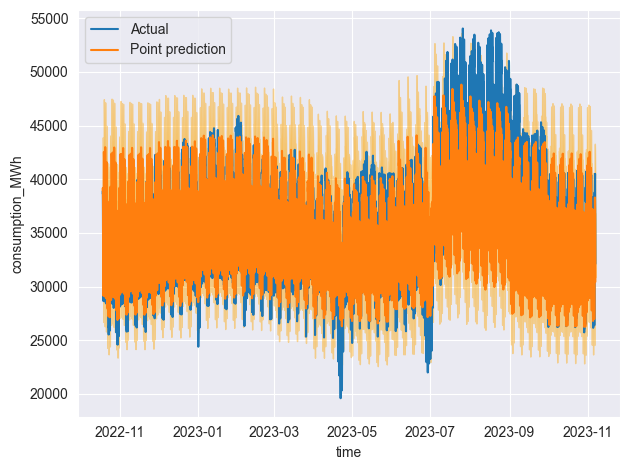

In [51]:
# Predicted vs. actual plot, hourly, entire test period
_ = sns.lineplot(
    data = df_test_output,
    x = "time",
    y = "consumption_MWh",
    label = "Actual"
)

_ = sns.lineplot(
    data = df_preds,
    x = "time",
    y = "pred_point",
    label = "Point prediction"
)

_ = plt.fill_between(
    x = df_preds.time,
    y1 = df_preds.pred_low,
    y2 = df_preds.pred_high,
    label = "95% prediction interval",
    color = "orange",
    alpha = 0.4
)

In [ ]:
# Predicted vs. actual plot, with input sequences

In [ ]:
# Predicted vs. actual plot, zoomed in to 2-4 input/output sequences?

In [ ]:
# Predicted vs. actual plot, daily?

In [ ]:
# Calculate performance metrics: MAE, RMSLE, MAPE